2024-10-30 18:15:30.844135: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 18:15:30.888453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keys:  ['maps', 'polys']


/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


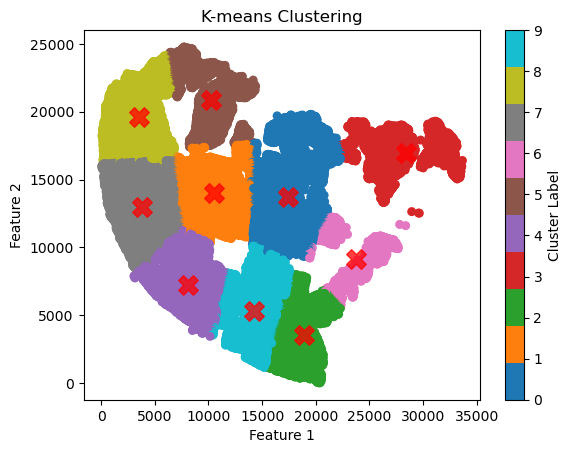

In [1]:
from _utils import *

dataset_dir = '/mnt/home/tudomlumleart/ceph/16_EmbryoDataset/E10p5_datasets'
dna_xy_path = os.path.join(dataset_dir, 'dna_aligned_XY.csv')
dna_trace_path = os.path.join(dataset_dir, 'E10p5_DNA.mat')
rna_spot_path = os.path.join(dataset_dir, 'rnaSpots.csv')

dna_xy = pd.read_csv(dna_xy_path)
rna_spot = pd.read_csv(rna_spot_path)

with h5py.File(dna_trace_path, 'r') as file:
    # List all datasets in the file
    print("Keys: ", list(file.keys()))
    
    dna_maps = file['maps'][:]
    dna_polys = file['polys'][:]

# Perform k-means clustering on the xy data
from sklearn.cluster import KMeans

n_clusters = 10
# Create a KMeans instance with the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(dna_xy)

# Get the cluster centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Plotting the clusters and centroids
scatter = plt.scatter(dna_xy.iloc[:, 0], dna_xy.iloc[:, 1], c=labels, s=30, cmap='tab10')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Create a color bar
cbar = plt.colorbar(scatter, ticks=range(n_clusters))  # Adjust ticks to match the number of clusters
cbar.set_label('Cluster Label')
cbar.set_ticks(np.arange(n_clusters))  # Labels for each cluster

plt.show()

In [2]:
# Iterate through the clusters and extract distance maps from that cluster
unique_labels = np.unique(labels)
cluster_maps = []
cluster_polys = []
for label in unique_labels:
    cluster_indices = np.where(labels == label)[0]
    cluster_maps.append(dna_maps[cluster_indices])
    cluster_polys.append(dna_polys[cluster_indices])
    
# Find the median maps in different clusters 
median_maps = [np.nanmedian(cluster, axis=0) for cluster in cluster_maps]

# Interpolate the DNA polys 
cluster_polys_interp = []
for cluster in cluster_polys:
    # transpose clusters such that the number of cells is the third dimension
    cluster = np.transpose(cluster, (2, 1, 0))
    print(cluster.shape)
    cluster_polys_interp.append(interpolate_polymers(cluster))
    
cluster_maps_interp = []
cluster_maps_interp_flat = []
for cluster in cluster_polys_interp:
    map_interp = calculate_distance_map(cluster)
    cluster_maps_interp.append(map_interp)
    cluster_maps_interp_flat.append([x.flatten() for x in map_interp])
    
all_maps_interp_flat = np.concatenate(cluster_maps_interp_flat, axis=0) 

(66, 3, 12335)
(66, 3, 8378)
(66, 3, 11637)
(66, 3, 7614)
(66, 3, 10545)
(66, 3, 6301)
(66, 3, 4480)
(66, 3, 7746)
(66, 3, 8990)
(66, 3, 9667)


In [11]:
def calculate_rg(polys):
    # calculate the radius of gyration for each polymer
    rg = []
    num_cells = polys.shape[2]
    for c in range(num_cells):
        poly = polys[:, :, c]
        rg.append(np.sqrt(np.sum(np.square(poly - np.mean(poly, axis=0))) / len(poly)))
    return rg

In [12]:
cluster_rg = [calculate_rg(cluster) for cluster in cluster_polys_interp]

In [26]:
cluster_rg_pre = [calculate_rg(cluster[:42, :, :]) for cluster in cluster_polys_interp]
cluster_rg_post = [calculate_rg(cluster[42:, :, :]) for cluster in cluster_polys_interp]

# this is not a good analysis because the boundary moves in different clusters

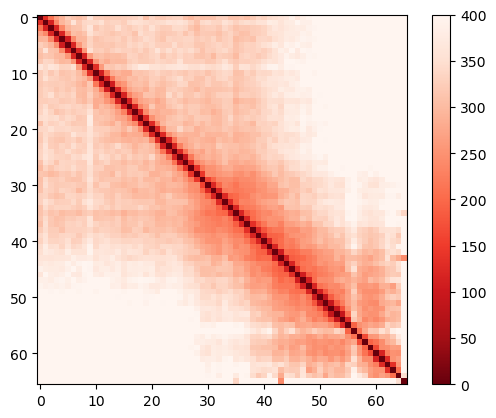

In [38]:
plt.imshow(median_maps[5], cmap='Reds_r', vmax=400)
plt.colorbar()


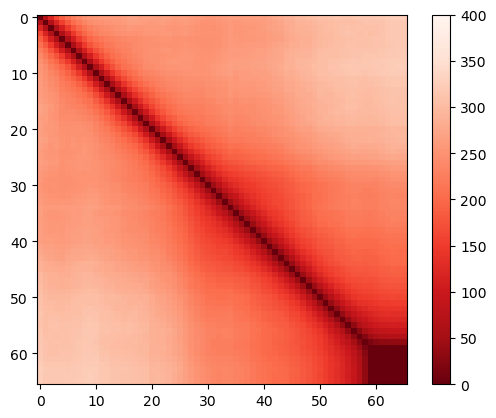

In [45]:
plt.imshow(np.nanmedian(cluster_maps_interp[3], axis=0), cmap='Reds_r', vmax=400)
plt.colorbar()

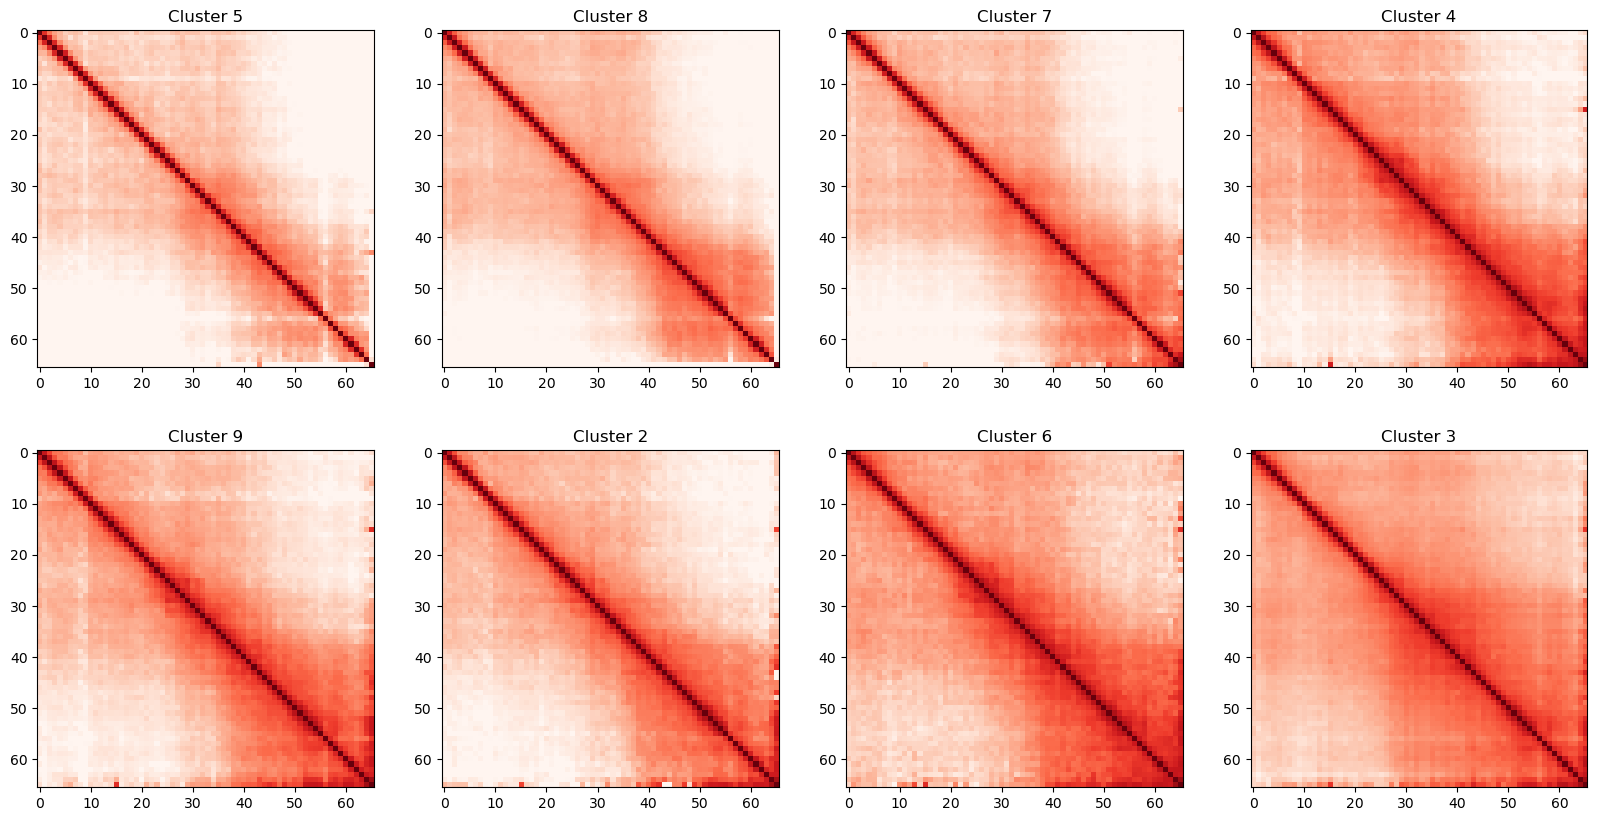

In [40]:
order_index = [5, 8, 7, 4, 9, 2, 6, 3]
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in zip(order_index, axs.flat):
    ax.imshow(median_maps[i], cmap='Reds_r', vmax=400)
    ax.set_title(f'Cluster {i}')

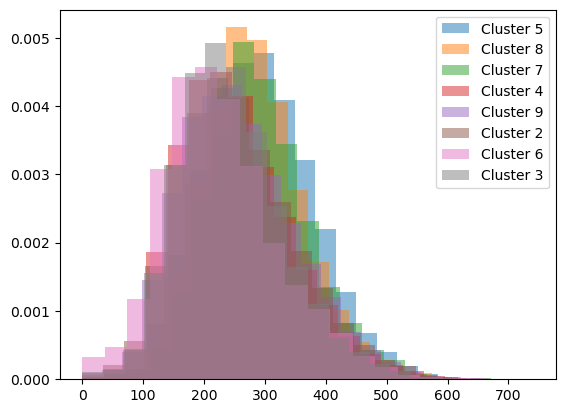

In [15]:
order_index = [5, 8, 7, 4, 9, 2, 6, 3]
for index in order_index:
    plt.hist(cluster_rg[index], label=f'Cluster {index}', alpha=0.5, bins=20, density=True)
plt.legend()

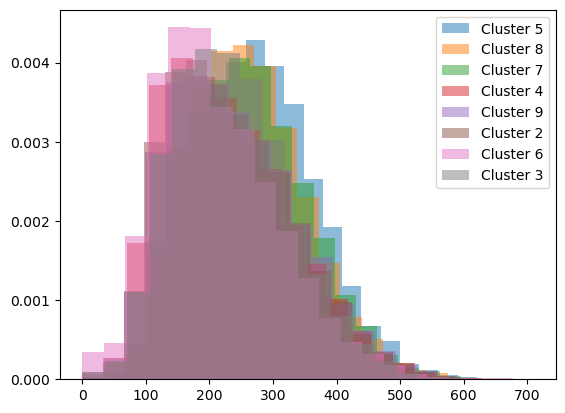

In [27]:
order_index = [5, 8, 7, 4, 9, 2, 6, 3]
for index in order_index:
    plt.hist(cluster_rg_pre[index], label=f'Cluster {index}', alpha=0.5, bins=20, density=True)
plt.legend()

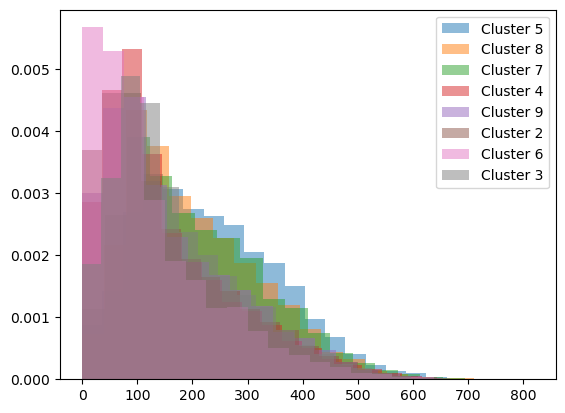

In [28]:
order_index = [5, 8, 7, 4, 9, 2, 6, 3]
for index in order_index:
    plt.hist(cluster_rg_post[index], label=f'Cluster {index}', alpha=0.5, bins=20, density=True)
plt.legend()

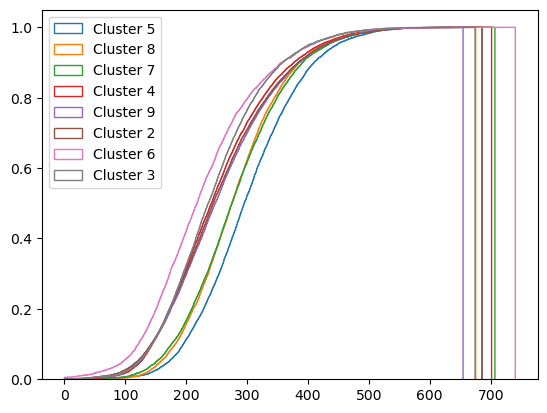

In [21]:
order_index = [5, 8, 7, 4, 9, 2, 6, 3]
for index in order_index:
    plt.hist(cluster_rg[index], bins=1000, label=f'Cluster {index}',  density=True, cumulative=True, histtype='step')
plt.legend()

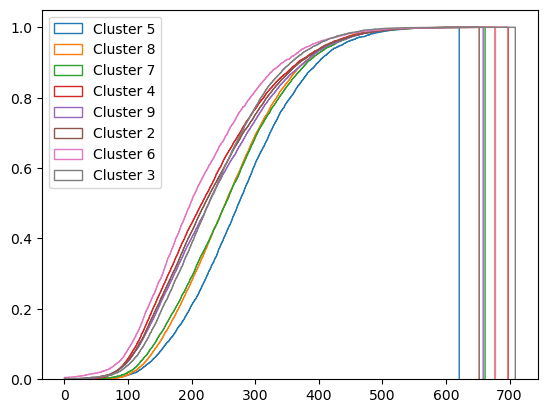

In [29]:
order_index = [5, 8, 7, 4, 9, 2, 6, 3]
for index in order_index:
    plt.hist(cluster_rg_pre[index], bins=1000, label=f'Cluster {index}',  density=True, cumulative=True, histtype='step')
plt.legend()

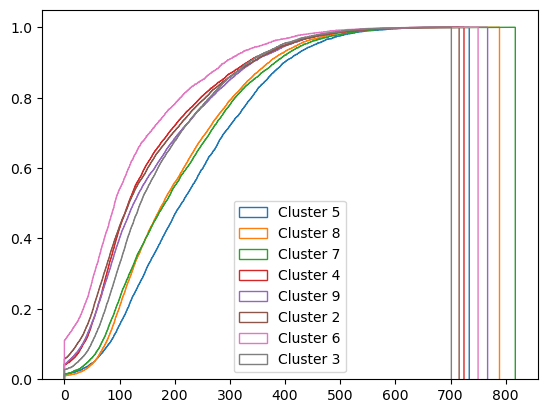

In [30]:
order_index = [5, 8, 7, 4, 9, 2, 6, 3]
for index in order_index:
    plt.hist(cluster_rg_post[index], bins=1000, label=f'Cluster {index}',  density=True, cumulative=True, histtype='step')
plt.legend()

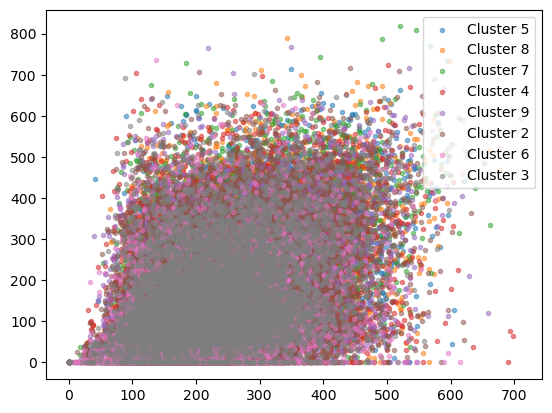

In [32]:
for index in order_index:
    pre_rg = cluster_rg_pre[index]
    post_rg = cluster_rg_post[index]
    plt.scatter(pre_rg, post_rg, label=f'Cluster {index}', alpha=0.5, marker='.')
plt.legend()

In [47]:
cluster_polys_interp[0].shape

(66, 3, 12335)

In [50]:
# Perform kmeans clustering on the DNA polymer
cluster_labels_list = []
cluster_centroids_list = []
for cluster in tqdm(cluster_polys_interp):
    num_cells = cluster.shape[2]
    labels_list = []
    centroids_list = []
    for c in range(num_cells):
        poly = cluster[:, :, c]
        kmeans = KMeans(n_clusters=2)
        kmeans.fit(poly)
        labels = kmeans.labels_ 
        centroids = kmeans.cluster_centers_
        labels_list.append(labels)
        centroids_list.append(centroids)
    
    cluster_labels_list.append(labels_list)
    cluster_centroids_list.append(centroids_list)
        

  0%|          | 0/10 [00:00<?, ?it/s]

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/sklearn/cluster/_kmea